If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_ → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Problem 4.2. Random Forests

In this problem, we will use the Random Forests classifier to see if we can use machine learning techniques to predict departure delays at the O'Hare airport (ORD).

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import ensemble
from sklearn.cross_validation import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, auc

from nose.tools import assert_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [Problem 4.1](https://github.com/lcdm-uiuc/info490-sp17/blob/master/Week4/assignments/w4p1.ipynb), we had a data frame with weather information. I dumped the `local_visi` data frame from the previous problem to create a CSV file. We will use this file to prepare our data set.

```python
>>> print(local_visi.head())
```

```
        Month  DayofMonth  CRSDepTime  Delayed  Visibility
398444      1           1        1905        1          10
398445      1           2        1905        1           9
398446      1           3        1905        1           5
398447      1           4        1905        0           8
398448      1           5        1905        1          10
```

In [2]:
local_visi = pd.read_csv('/home/data_scientist/data/weather/local_visi.csv', index_col=0) 
print(local_visi.head())

        Month  DayofMonth  CRSDepTime  Delayed  Visibility
398444      1           1        1905        1        10.0
398445      1           2        1905        1         9.0
398446      1           3        1905        1         5.0
398447      1           4        1905        0         8.0
398448      1           5        1905        1        10.0


For the Random Forests classifier, we will add more columns than what we used in Problem 4.1 (i.e., the columns in `local_visi`), so let's import the following columns from `2001.csv`.

- Column 1: Month, 1-12
- Column 2: DayofMonth, 1-31
- Column 3: DayOfWeek, 1 (Monday) - 7 (Sunday)
- Column 5: CRSDepTime, scheduled departure time (local, hhmm)
- Column 7: CRSArrTime, scheduled arrival time (local, hhmm)
- Column 18: Distance, in miles

In [3]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(1, 2, 3, 5, 7, 18)
    )

We can use the index of `local_visi` to extract the rows we need.

```python
>>> print(local.head())
```

```
   Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Visibility  \
0      1           1          1        1905        2159      1846          10   
1      1           2          2        1905        2159      1846           9   
2      1           3          3        1905        2159      1846           5   
3      1           4          4        1905        2159      1846           8   
4      1           5          5        1905        2159      1846          10   

   Delayed  
0        1  
1        1  
2        1  
3        0  
4        1  
```

In [4]:
df = df.loc[local_visi.index, :]
df.loc[local_visi.index, 'Visibility'] = local_visi['Visibility']
df.loc[local_visi.index, 'Delayed'] = local_visi['Delayed']
local = df.reset_index(drop=True) # easier to reset the index in this problem

print(local.head())

   Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Visibility  \
0      1           1          1        1905        2159      1846        10.0   
1      1           2          2        1905        2159      1846         9.0   
2      1           3          3        1905        2159      1846         5.0   
3      1           4          4        1905        2159      1846         8.0   
4      1           5          5        1905        2159      1846        10.0   

   Delayed  
0        1  
1        1  
2        1  
3        0  
4        1  


## Split

This function is the same function from [Problem 3.1](https://github.com/lcdm-uiuc/info490-sp17/blob/master/Week3/assignments/w3p1.ipynb). You can copy-paste your answer. I'll try not to make you write this again in the future.

In [5]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    # YOUR CODE HERE
    df1 = df.drop(test_column, 1) # create new df without test_column
    # split into train and test sets
    (X_train, X_test, y_train, y_test) = train_test_split(df1, df[test_column], test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

We split `local_visi` into 80:20 training and test sets.

In [6]:
X_train, X_test, y_train, y_test = split(
    df=df,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

## Use sklearn.KFold

In the previous problems, we used a validation set to adjust the hyperparameters. The <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation">k-fold cross-validation</a> technique extends the idea of validation set. You can read more about $k$-fold CV on Wikipedia or [scikit-learn docs](http://scikit-learn.org/stable/modules/cross_validation.html).

We are going to use $k$-fold CV to

1. measure the performance increase with increasing number of trees, and
2. optimize one of the hyperparameters, `max_features`.

I'm going to break the process into small steps, but in practice it might be better to combine all the steps and write everything into one or two functions.

- Use [sklearn.cross_validation.KFold()](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html) to write a function named `get_cv_indices()` that takes a data frame and returns a $k$-fold cross-validation iterator.

In [7]:
def get_cv_indices(df, n_folds, random_state):
    '''
    Provides train/test indices to split data in train test sets.
    Split dataset into "n_folds" consecutive folds (no shuffling).
    
    Paramters
    ---------
    df: A pandas.DataFrame
    n_folds: integer
    random_state: A numpy.random.RandomState instance

    Returns
    -------
    An sklearn.cross_validation.KFold instance.
    '''
    
    # YOUR CODE HERE
    # deprecated, should be model_selection
    # KFold to split 
    result = KFold(n=len(df.index), n_folds=n_folds, random_state=random_state)
    
    return result

In [8]:
test_kf = get_cv_indices(
    pd.DataFrame({'a': np.arange(1000)}), 10, check_random_state(1)
    )
assert_is_instance(test_kf, KFold)
assert_equal(test_kf.n, 1000)
assert_equal(test_kf.n_folds, 10)
assert_array_equal(test_kf.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

## Random Forest Classifier

We are going to use the Random Forest classifier and adjust two hyperparameters, `n_estimators` and `max_features`. You should use default values for all other parameters.

`n_estimators` represents the number of trees in the forest, and the default value is 10, which is usually too small for big data sets. It is somewhat trivial to find the best value, because the classifer performance usually increases with the number of trees. So you should have as many trees as possible, but only up to a point because you get diminishing returns once you have enough trees.

`max_features` is the number of features that are considered for each split. In my experience, this is the most important parameter. The rule of thumb that gets thrown around a lot is the square root of total number of features, but it's best to fine tune this parameter.

- Write a function named `get_rfc()` that accepts two hyperparameters, `n_estimators` and `max_featurs` (don't forget the `random_state`). It returns an `sklearn.RandomForestClassifier` instance.

In [9]:
def get_rfc(n_estimators, max_features, random_state):
    '''
    A random forest classifier with two adjustable parameters:
    "n_estimators" and "max_features".
    Uses the default sklearn values for the remaining parameters.
    
    Parameters
    ----------
    n_estimators: An int
    max_features: An int
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.ensemble.forest.RandomForestClassifier
    '''
    
    # YOUR CODE HERE
    
    from sklearn.ensemble import RandomForestClassifier
    # RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=random_state)
    
    return rfc

In [10]:
test_rfc = get_rfc(100, 10, check_random_state(1))
assert_is_instance(test_rfc, ensemble.RandomForestClassifier)
assert_equal(test_rfc.n_estimators, 100)
assert_equal(test_rfc.max_features, 10)
assert_array_equal(test_rfc.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

## Fit and predict

- Write a function named `get_proba()` that makes probabilistic predictions on the validation set.

You should make **probabilistic** predictions. Use [predict_proba()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba).

The paremeters `idx_train` and `idx_valid` are what you would get from the `get_cv_indices()` iterator. For example, 

```python
>>> example_kf = get_cv_indices(
...     pd.DataFrame({'a': np.arange(20)}), 4, check_random_state(1)
...     )

>>> for idx_train, idx_valid in example_kf:
...     print(idx_train, idx_valid)
```

```
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3 4]
[ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19] [5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19] [10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15 16 17 18 19]
```

And they are just numpy arrays:

```python
>>> print(type(idx_train))
```

```
<class 'numpy.ndarray'>
```

In [11]:
def get_proba(clf, X_train, y_train, idx_train, idx_valid):
    '''
    
    Fits the "clf" model on X_train[idx_train] and y_train[idx_train].
    Makes predictions on X_train[idx_valid].
    
    Parameters
    ----------
    clf: An sklearn classifier instance.
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    idx_train: A numpy array
    idx_valid: A numpy array
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    
    # YOUR CODE HERE
    
    # fit the model clf
    clf.fit(X_train.values[idx_train], y_train.values[idx_train])
    # prediction on the model
    y_pred = clf.predict_proba(X_train.values[idx_valid])
    
    return y_pred

In [12]:
test_X = pd.DataFrame({
    'X0': np.arange(10),
    'X1': np.arange(10),
    'X2': np.arange(10)
    })

test_y = pd.DataFrame({
    'y': np.arange(10)
    })

test_rfc = get_rfc(10, 2, check_random_state(2))

test_proba = get_proba(test_rfc, test_X, test_y,
    np.arange(10)[::2], np.arange(10)[::2] + 1)

assert_array_equal(test_proba,
    np.array(
        [[ 0.6,  0.2,  0.1,  0.1,  0. ],
         [ 0. ,  0.6,  0.3,  0.1,  0. ],
         [ 0. ,  0.2,  0.5,  0.3,  0. ],
         [ 0. ,  0.1,  0.1,  0.5,  0.3],
         [ 0. ,  0.1,  0.1,  0.1,  0.7]])
    )

## Area under the ROC curve

- Write a function named `get_auc()` that uses the `get_proba()` function to train a Random Forest classifier (`rfc`) on a subset of X_train/y_train, makes predictions on the validation data, and returns a one-dimensional Numpy array.

The $k$-th element in the array is the AUC score evaluated on the $k$-th cross-validation data. So if we use 10-fold cross-validation, we will get a Numpy array with length 10.

In [22]:
def get_auc(kf, rfc, X_train, y_train):
    '''
    Iterates through the cross-validation folds and
    returns the area under the ROC curve for the validation data.
    
    Parameters
    ----------
    kf: An sklearn.KFold instance
    rfc: An sklearn.RandomForestClassifer instance
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    
    Returns
    -------
    A numpy array
    '''
    
    # YOUR CODE HERE
    
    # initialize numpy array
    result = np.array([])
    
    # iterate through the kfold instance
    for i, j in kf:
        prediction = get_proba(rfc, X_train, y_train, i, j)
        # false positive rates, true positive rates
        fpr, tpr, thresholds = roc_curve(y_train.values[j], prediction[:,1])
        
        result = np.append(result, auc(fpr, tpr))
        
    return result

In [23]:
test_X = pd.DataFrame({
    'X0': np.arange(100),
    'X1': np.arange(100),
    'X2': np.arange(100)
    })

test_y = pd.DataFrame({
    'y': [0, 1] * 50
    })

test_kf = get_cv_indices(test_X, 10, check_random_state(1))

test_rfc = get_rfc(10, 2, check_random_state(2))

test_auc = get_auc(test_kf, test_rfc, test_X, test_y)

assert_array_almost_equal(test_auc,
    [0.5, 0.44, 0.44, 0.4, 0.4, 0.48, 0.48, 0.38, 0.4, 0.5]
    )

## The number of trees

We will increase the number of trees from 10 to 100 and plot the relationship between the number of trees and the area under the ROC curve.

You don't have to write code for this part. Simply run the following two code cells.

```
Trees   AUC
------------
 10    0.702
 20    0.713
 30    0.720
 40    0.724
 50    0.727
 60    0.729
 70    0.729
 80    0.730
 90    0.730
100    0.731
```

As we increase the number of trees, we get better performance but diminishing returns. The gain in performance flattens out after about 100 trees.

![](./images/roc_vs_trees.png)

In [24]:
result = []

print('Trees   AUC\n'
      '------------')

for n_trees in range(10, 110, 10):
    kf = get_cv_indices(X_train, 3, check_random_state(0))
    rfc = get_rfc(n_trees, 3, check_random_state(0))
    mean_auc = get_auc(kf, rfc, X_train, y_train).mean()
    result.append((n_trees, mean_auc))
    print('{0:3d}    {1:0.3f}'.format(n_trees, mean_auc))

Trees   AUC
------------
 10    0.702
 20    0.713
 30    0.720
 40    0.724
 50    0.727
 60    0.729
 70    0.729
 80    0.730
 90    0.730
100    0.731


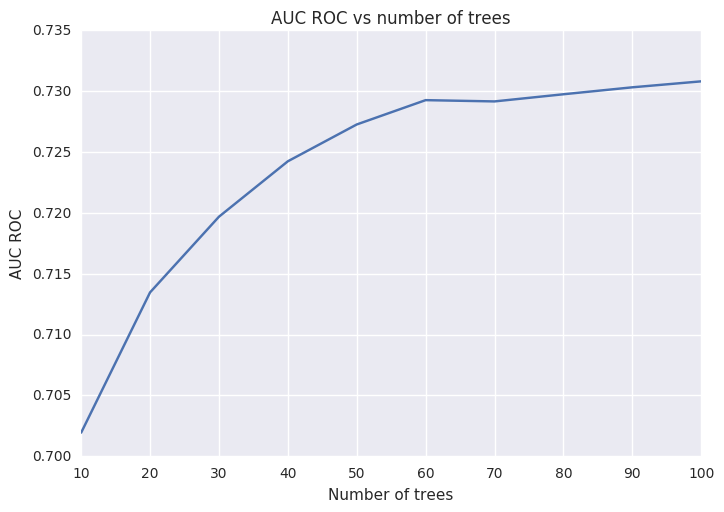

In [25]:
result = np.array(result)
fig, ax = plt.subplots()

ax.plot(result[:, 0], result[:, 1])
ax.set_title('AUC ROC vs number of trees')
ax.set_xlabel('Number of trees')
ax.set_ylabel('AUC ROC')

## Optimize number of features

Vary the number of features at each split to find the best values of `max_features`. You should search from `max_features=1` to `max_features=7` inclusive.

Use 4-fold cross-validation, `n_folds=4`. We will also use `n_trees=20` to save time. But we will eventually train with 100 trees in the end, so in practice you should find the optimal hypermater with 100 trees. 

We need two different `check_random_state()` instances, one for `get_cv_indices()` and another one for `get_rfc()`.

In [37]:
def optimize_max_features(X_train, y_train, cv_random_state, clf_random_state, n_folds=4, n_trees=20):
    '''
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    cv_random_state: A RandomState instance for get_cv_indices()
    clf_random_state: A RandomState instance for get_auc()
    
    Optional
    --------
    n_folds: An int. 4 by default.
    n_trees: An int. 20 by default.
    
    Returns
    --------
    A list of (max_features value, corresponding mean AUC value) tuples.
    '''

    # YOUR CODE HERE
    
    # initialize list
    result = []
    max_features = range(1,8)
    
    # iterate through max_features
    for i in max_features:
        # get kf instance
        kf = get_cv_indices(X_train, n_folds=n_folds, random_state=cv_random_state)
        # get rfc instance
        rfc = get_rfc(n_estimators=n_trees, max_features=i, random_state=clf_random_state)
        # get auc score cross valid with kfc, rfc
        auc = np.mean(get_auc(kf, rfc, X_train, y_train))
        # add tuple list
        result.append((i, auc))
        
    return result

Run a short test in the following code cell to check if your function behaves correctly.

In [38]:
test_omf = optimize_max_features(X_train[:100], y_train[:100], check_random_state(0), check_random_state(0))
assert_is_instance(test_omf, list)
assert_array_almost_equal(test_omf,
    [(1, 0.70678053830227749),
     (2, 0.69804606625258803),
     (3, 0.76811594202898559),
     (4, 0.73311335403726707),
     (5, 0.65430900621118004),
     (6, 0.69998706004140798),
     (7, 0.68711180124223614)]
    )

If your function passes the above tests, run the following cell to compute average AUC for different values of `max_features`.

In [39]:
max_features = optimize_max_features(X_train, y_train, check_random_state(0), check_random_state(0))

It looks like our classifier performs best when we use `max_features=4`.

```python
>>> print('The best value for max_features is {}.'.format(best_max_features))
```

```
The best value for max_features is 4.
```

In [40]:
best_max_features = np.argmax(np.array(max_features)[:, 1]) + 1
print('The best value for max_features is {}.'.format(best_max_features))
assert_equal(best_max_features, 4)

The best value for max_features is 4.


## Final Random Forest model

Now that we have optimized the `max_features` parameter, let's use this value to train a model with `max_features=5` and `n_trees=100`. Once we train the model on the entire training set, we will make probabilistic preditions for the test set.

You should make **probabilistic** predictions. Use `predict_proba()`.

In [41]:
def get_final_rfc(X_train, y_train, X_test, max_features, random_state, n_trees=100):
    '''
    Trains a Random Forest classifier on the entire training set
    using the optimized "max_features".
    Makes probabilistic predictions.
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    X_test: A pandas.DataFrame
    max_features: An int
    random_state: A RandomState instance
    
    Optional
    --------
    n_trees: An int. 100 by default
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    
    # YOUR CODE HERE
    
    # acquire rfc instance
    rfc = get_rfc(n_trees, max_features, random_state)
    # fit the rfc, generate prediction
    rfc.fit(X_train.values, y_train.values)
    y_pred = rfc.predict_proba(X_test.values)
    
    return y_pred

When you run `get_final_rfc()` in the following code cell, `y_pred` will be a two-dimensional array.

```python
>>> print(y_pred)
```

```
[[ 0.63  0.37]
 [ 0.98  0.02]
 [ 0.93  0.07]
 ..., 
 [ 0.99  0.01]
 [ 0.98  0.02]
 [ 0.89  0.11]]
```

Think about why it is a two-dimensional array.

In [42]:
y_pred = get_final_rfc(X_train, y_train, X_test, best_max_features, check_random_state(0))

In [43]:
assert_is_instance(y_pred, np.ndarray)
assert_array_almost_equal(y_pred[:5],
    [[ 0.67,  0.33],
     [ 0.99,  0.01],
     [ 0.94,  0.06],
     [ 0.98,  0.02],
     [ 0.84,  0.16]]
    )
assert_array_almost_equal(y_pred[-5:],
    [[ 0.79,  0.21],
     [ 0.86,  0.14],
     [ 1.,    0.  ],
     [ 0.96,  0.04],
     [ 0.9,   0.1 ]]
    )

## Plot ROC curve

- Use `sklearn.roc_curve()` to plot the ROC curve. The False Positive Rate should go on the $x$-axis, and the True Positive Rate on the $y$-axis. Your plot should have a title and axis labels. You should also display the area under the ROC curve in a legend.

Here's an example:

![](./images/roc.png)

In [92]:
def plot_roc_curve(y_test, y_pred):
    '''
    Plots ROC curve with FPR on the x-axis and TPR on the y-axis.
    Displays AUC ROC in the legend.
    
    Paramters
    ---------
    y_test: A pandas.DataFrame
    y_pred: A two dimensional array from get_final_rfc()
    
    Returns
    -------
    A matplotlib.Axes instance
    '''
    
    # YOUR CODE HERE
    
    # initialize graph
    fig, ax = plt.subplots()
    # roc curve
    (fpr, tpr, thresholds) = roc_curve(y_test, y_pred[:,1])
    
    # get auc score
    auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Area = ' + str('%.2f' % auc_score))
    
    # set style with seaborn
    sns.set(style="white", font_scale=2.0)
    sns.despine(left='true',bottom='true')
    
    # set axes,label,legend
    ax.set(title='ROC Curve',
       xlabel='False Positive Rate', xlim=(0.0,1.0),
       ylabel='True Positive Rate', ylim=(0.0,1.0))
    ax.legend(loc='lower right')


    return ax

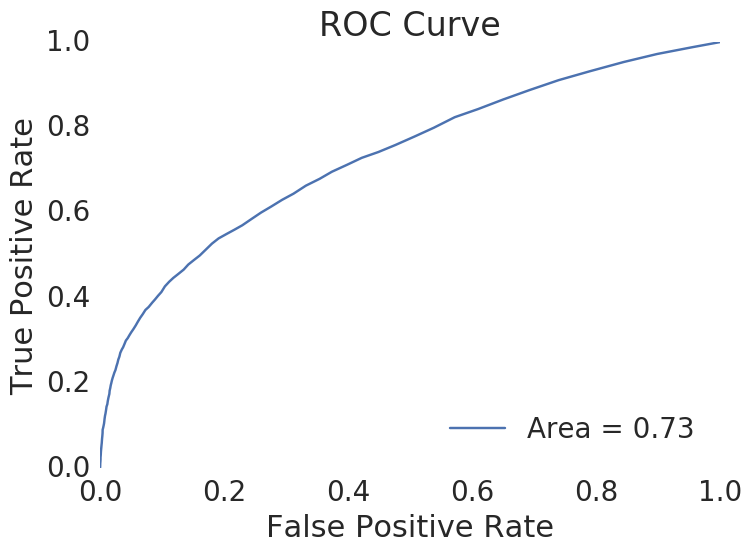

In [93]:
ax = plot_roc_curve(y_test, y_pred)

In [94]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")
    
line = ax.get_lines()[0]
xdata = line.get_xdata()
ydata = line.get_ydata()
assert_array_almost_equal(
    xdata[:5], 
    [  0.00000000e+00,   5.76103238e-05,   2.30441295e-04,   3.45661943e-04,
   5.76103238e-04]
    )
assert_array_almost_equal(
    ydata[:5],
    [ 0. ,         0.00182768,  0.00496084,  0.01148825,  0.0154047 ])

handles, labels = ax.get_legend_handles_labels()
assert_equal('area' in labels[0].lower() or 'auc' in labels[0].lower(), True)
assert_equal('{:0.2f}'.format(roc_auc_score(y_test, y_pred[:, 1])) in labels[0], True)